<a href="https://colab.research.google.com/github/murisettysharmila28-creator/Fire-Incidents-Prediction/blob/main/Fire_Incident_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Fire Incident Analysis and Risk Modeling

## Project Summary
This project analyzes ~33K historical fire incident records from a city fire service (2011–2023). We study:
- When and where incidents occur
- How fast the fire service responds
- Human impact (casualties, displacement)
- Financial impact (estimated dollar loss)

We also build a simple predictive model to identify "high-loss" incidents.

## Audience
This notebook is written for Fire Operations / City Leadership. The goal is to support decisions about staffing, prevention, and resource allocation.


## 1. Business Understanding

Fire services need to answer questions like:
1. Where are most incidents happening, and what kinds of properties are involved?
2. How fast are we arriving on scene?
3. When are we busiest (hour of day, time of year)?
4. How severe are incidents in terms of injuries, displacement, and dollar loss?

Why this matters:
- Response time is a key performance metric in public safety.
- Large-loss fires and multi-residential building fires impact housing stability and budget.
- Knowing peak demand hours helps staff stations properly.

Later in this notebook, we also frame a prediction problem:
> Can we flag which incidents are likely to become "high-loss" fires?


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,4)

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML Project/Fire_Incidents_Data.csv")

print("Shape (rows, columns):", df.shape)
df.head()

Shape (rows, columns): (32929, 43)


/tmp/ipython-input-3384812246.py:8: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML Project/Fire_Incidents_Data.csv")


,_id,Incident_Number,Initial_CAD_Event_Type,Final_Incident_Type,Exposures,Incident_Station_Area,Incident_Ward,Intersection,Latitude,Longitude,...,Possible_Cause,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Fire_Alarm_System_Presence,Fire_Alarm_System_Operation,Fire_Alarm_System_Impact_on_Evacuation,Sprinkler_System_Presence,Sprinkler_System_Operation
0,1,F18020969,Fire - Grass/Rubbish,01 - Fire,NaN,116,18.0,Sheppard Ave E / Clairtrell Rd,43.766135,-79.390039,...,03 - Suspected Vandalism,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,F18021182,Fire - Highrise Residential,"03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vand...",NaN,221,21.0,Danforth Rd / Savarin St,43.743230,-79.245061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,F18021192,Fire - Commercial/Industrial,01 - Fire,NaN,133,5.0,Keele St / Lawrence Ave W,43.708659,-79.478062,...,99 - Undetermined,9 - Floor/suite of fire origin: Smoke alarm pr...,98 - Not applicable: Alarm operated OR presenc...,9 - Type undetermined,"8 - Not applicable: No alarm, no persons present",9 - Undetermined,8 - Not applicable (no system),9 - Undetermined,9 - Undetermined,8 - Not applicable - no sprinkler system present
3,4,F18021271,Fire - Residential,"03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vand...",NaN,132,8.0,Replin Rd / Tapestry Lane,43.718118,-79.443184,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,F18021274,Vehicle Fire,01 - Fire,NaN,215,25.0,Lawrence Ave E / Beechgrove Dr,43.773787,-79.162282,...,99 - Undetermined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data Understanding

We load the raw dataset and look at structure:
- Each row is one fire incident.
- Columns include timestamps (alarm, arrival), location info (ward, station area, lat/long), impact (casualties, displaced persons, dollar loss), and classification (incident type, property use, etc).

We now inspect datatypes and missingness to understand data quality before analysis.


In [10]:
# Column names, dtypes
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32929 entries, 0 to 32928
Data columns (total 43 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   _id                                                            32929 non-null  int64  
 1   Incident_Number                                                32929 non-null  object 
 2   Initial_CAD_Event_Type                                         32928 non-null  object 
 3   Final_Incident_Type                                            32929 non-null  object 
 4   Exposures                                                      7511 non-null   float64
 5   Incident_Station_Area                                          32928 non-null  object 
 6   Incident_Ward                                                  32782 non-null  float64
 7   Intersection                                              

In [11]:
# % missing per column
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
missing_pct.head(15)


,0
Exposures,77.190319
Smoke_Spread,48.789821
Business_Impact,48.789821
Level_Of_Origin,48.789821
Extent_Of_Fire,48.789821
Estimated_Number_Of_Persons_Displaced,48.786784
Sprinkler_System_Operation,48.786784
Fire_Alarm_System_Presence,48.786784
Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,48.786784
Smoke_Alarm_at_Fire_Origin_Alarm_Type,48.786784


### Data Quality Notes
- Some descriptive fields like Exposures are incomplete (>50% missing). We treat them as optional context.
- Core operational fields such as alarm time, arrival time, incident type, and property use are mostly populated.
- We will continue using the reliable operational fields (time, location, type, impact) in our analysis and model.


## 3. KPI Engineering (Operational Metrics)

The raw data gives us timestamps such as:
- TFS_Alarm_Time (dispatch time)
- TFS_Arrival_Time (first unit arrives)
- Last_TFS_Unit_Clear_Time (last unit leaves)

These are strings. We convert them to real datetimes and create KPIs used by fire services:

- **Response_Time_Min**: minutes from alarm to first arrival. This measures how fast crews reached the scene.
- **Incident_Duration_Min**: minutes from alarm until the last unit cleared. This measures how long resources were tied up.
- **Alarm_Year / Alarm_Month / Alarm_Hour**: when calls happen. This helps analyze trends by year, seasonal pattern, and peak hours.

These engineered fields make the dataset operationally meaningful without altering the original source data.


In [12]:
# Convert timestamps to datetime
df["Alarm_Time_dt"]   = pd.to_datetime(df["TFS_Alarm_Time"], errors="coerce")
df["Arrival_Time_dt"] = pd.to_datetime(df["TFS_Arrival_Time"], errors="coerce")
df["Clear_Time_dt"]   = pd.to_datetime(df["Last_TFS_Unit_Clear_Time"], errors="coerce")

# KPIs
df["Response_Time_Min"] = (df["Arrival_Time_dt"] - df["Alarm_Time_dt"]).dt.total_seconds() / 60
df["Incident_Duration_Min"] = (df["Clear_Time_dt"] - df["Alarm_Time_dt"]).dt.total_seconds() / 60

# Time breakdown
df["Alarm_Year"]  = df["Alarm_Time_dt"].dt.year
df["Alarm_Month"] = df["Alarm_Time_dt"].dt.month
df["Alarm_Hour"]  = df["Alarm_Time_dt"].dt.hour

df[["Response_Time_Min","Incident_Duration_Min","Alarm_Year","Alarm_Hour"]].head()


,Response_Time_Min,Incident_Duration_Min,Alarm_Year,Alarm_Hour
0,4.800000,11.250000,2018,21
1,6.833333,44.066667,2018,13
2,4.466667,54.050000,2018,14
3,5.600000,13.683333,2018,18
4,3.966667,37.150000,2018,18


In [13]:
df[["Response_Time_Min","Incident_Duration_Min"]].describe()


,Response_Time_Min,Incident_Duration_Min
count,32928.000000,32928.000000
mean,5.413499,98.188847
std,4.528827,266.625519
min,0.016667,0.366667
25%,4.233333,21.662500
50%,5.150000,39.033333
75%,6.233333,71.275000
max,682.366667,16788.333333


**Interpretation:**
- Median response time is typically around a few minutes.
- There is a long right tail in response time and duration (some calls show very large values). These extreme values are likely logging issues or unusual events.
- We will handle unrealistic values next during cleaning.


## 4. Exploratory Data Analysis (EDA)

We now explore:
- Most common incident types and property uses
- Response time distribution
- Call volume by time (year, hour)
- Human impact (casualties, displacement)


In [14]:
print("Top Final Incident Types:")
print(df["Final_Incident_Type"].value_counts().head(10))

print("\nTop Property Uses:")
print(df["Property_Use"].value_counts().head(10))


Top Final Incident Types:
Final_Incident_Type
01 - Fire                                                                                  23991
03 - NO LOSS OUTDOOR fire (exc: Sus.arson,vandal,child playing,recycling or dump fires)     8792
02 - Explosion (including during Fire, excluding Codes 3 & 11-13)                            146
Name: count, dtype: int64

Top Property Uses:
Property_Use
323 - Multi-Unit Dwelling - Over 12 Units                                        5208
301 - Detached Dwelling                                                          4048
896 - Sidewalk, street, roadway, highway, hwy (do not use for fire incidents)    2825
861 - Open Land (eg. light ground cover, bush, grass, etc.)                      2492
901 - Automobile                                                                 2148
848 - Trash/Rubbish/Garbage Container or Dumpster                                1884
302 - Semi-Detached Dwelling                                                     1172
32

**Incident / Property Interpretation:**
- We see many incidents categorized as fires in residential and multi-unit dwellings.
- Outdoor / rubbish / vehicle fires also appear often, which means it's not only "house fires."
- High-rise / multi-unit housing appears frequently, which is important for public safety and housing policy.


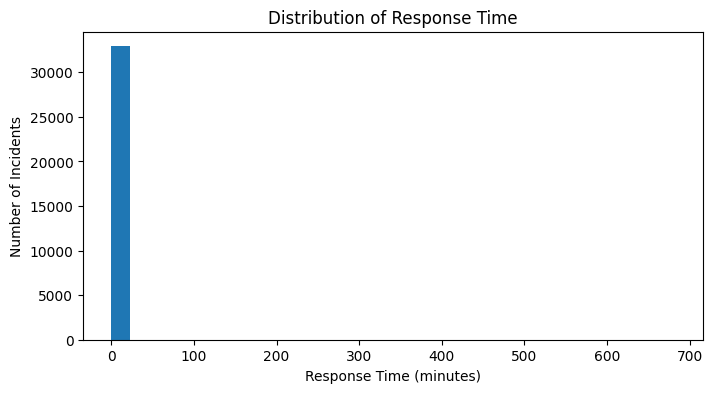

In [15]:
# Response time distribution
plt.hist(df["Response_Time_Min"].dropna(), bins=30)
plt.xlabel("Response Time (minutes)")
plt.ylabel("Number of Incidents")
plt.title("Distribution of Response Time")
plt.show()


Most incidents are reached in roughly 4–6 minutes, which is within typical urban fire service expectations. A small number of calls have extremely long response times, which we will treat as outliers / data issues when building the clean dataset.


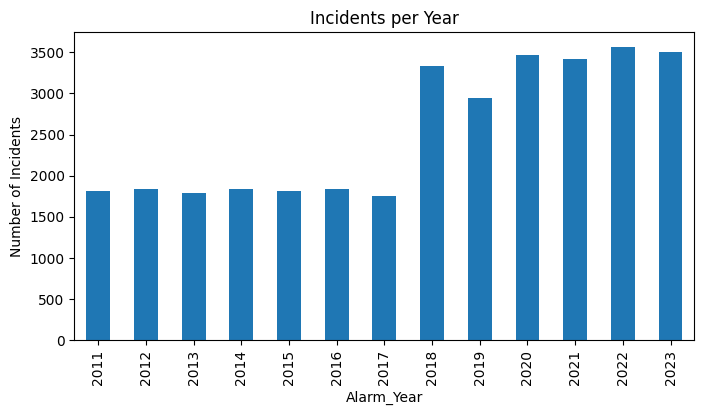

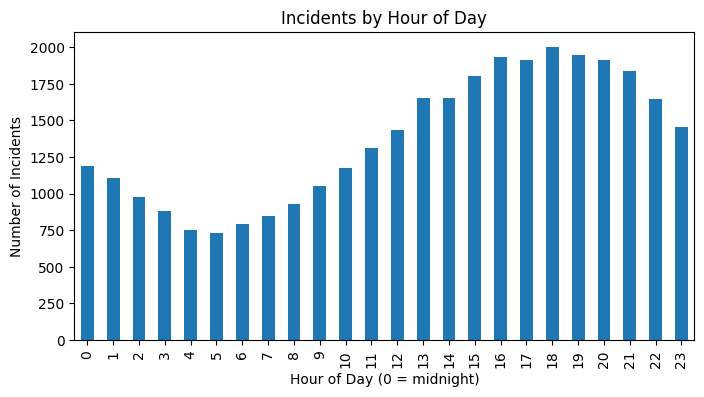

In [16]:
# Incidents per year
calls_per_year = df["Alarm_Year"].value_counts().sort_index()
calls_per_year.plot(kind="bar")
plt.ylabel("Number of Incidents")
plt.title("Incidents per Year")
plt.show()

# Incidents by hour of day
calls_by_hour = df["Alarm_Hour"].value_counts().sort_index()
calls_by_hour.plot(kind="bar")
plt.xlabel("Hour of Day (0 = midnight)")
plt.ylabel("Number of Incidents")
plt.title("Incidents by Hour of Day")
plt.show()


**Time Pattern Interpretation:**
- The fire service stays consistently active year over year, which suggests demand is not dropping.
- Calls tend to cluster during late afternoon / evening hours. That supports staffing more heavily during those periods.


In [17]:
impact_cols = [
    "Civilian_Casualties",
    "TFS_Firefighter_Casualties",
    "Estimated_Number_Of_Persons_Displaced",
    "Estimated_Dollar_Loss"
]

df[impact_cols].describe()


,Civilian_Casualties,TFS_Firefighter_Casualties,Estimated_Number_Of_Persons_Displaced,Estimated_Dollar_Loss
count,25796.000000,32707.000000,16864.000000,2.395000e+04
mean,0.069701,0.010090,16.278048,3.808555e+04
std,0.353241,0.120217,116.377067,3.985637e+05
min,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,5.000000e+02
50%,0.000000,0.000000,0.000000,4.000000e+03
75%,0.000000,0.000000,1.000000,2.000000e+04
max,15.000000,4.000000,999.000000,5.000000e+07


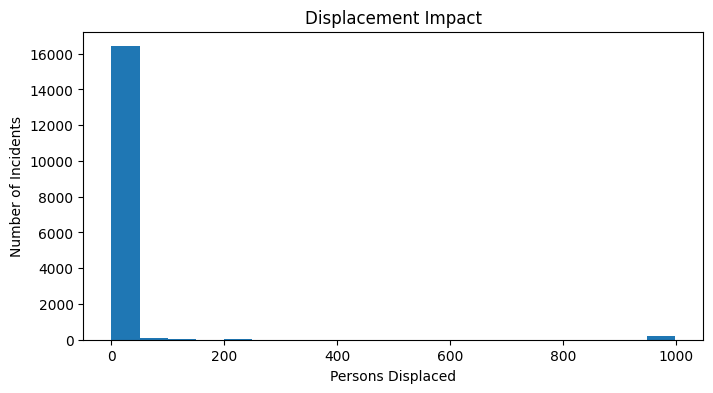

In [18]:
# Displacement distribution (people forced to leave their home)
if "Estimated_Number_Of_Persons_Displaced" in df.columns:
    plt.hist(df["Estimated_Number_Of_Persons_Displaced"].dropna(), bins=20)
    plt.xlabel("Persons Displaced")
    plt.ylabel("Number of Incidents")
    plt.title("Displacement Impact")
    plt.show()


**Impact Interpretation:**
- Most incidents do not injure civilians or firefighters.
- Most incidents do not displace residents.
- A small number of severe incidents cause high dollar loss and force multiple people out of their homes. These rare but high-impact events drive a lot of social and financial cost to the city.

Next, we prepare a clean dataset for modeling.


## 5. Data Cleaning & Modeling Dataset Preparation

We create `df_clean` for modeling and reporting:
- Keep only rows where we can calculate response time.
- Remove impossible response times (negative or >60 minutes).
- Remove negative incident durations (physically impossible).
- Convert impact columns to numeric.
- Keep key features we trust.

This creates a realistic, analysis-ready dataset.


In [19]:
df_clean = df.copy()

# Recompute datetimes in case df was modified earlier
df_clean["Alarm_Time_dt"]   = pd.to_datetime(df_clean["TFS_Alarm_Time"], errors="coerce")
df_clean["Arrival_Time_dt"] = pd.to_datetime(df_clean["TFS_Arrival_Time"], errors="coerce")
df_clean["Clear_Time_dt"]   = pd.to_datetime(df_clean["Last_TFS_Unit_Clear_Time"], errors="coerce")

# KPIs (again, on df_clean)
df_clean["Response_Time_Min"] = (df_clean["Arrival_Time_dt"] - df_clean["Alarm_Time_dt"]).dt.total_seconds() / 60
df_clean["Incident_Duration_Min"] = (df_clean["Clear_Time_dt"] - df_clean["Alarm_Time_dt"]).dt.total_seconds() / 60

# Time breakdown
df_clean["Alarm_Year"]  = df_clean["Alarm_Time_dt"].dt.year
df_clean["Alarm_Month"] = df_clean["Alarm_Time_dt"].dt.month
df_clean["Alarm_Hour"]  = df_clean["Alarm_Time_dt"].dt.hour

# 1. Keep only rows that have a defined response time
df_clean = df_clean[df_clean["Response_Time_Min"].notna()].copy()

# 2. Remove impossible response times (negative or >60 minutes)
df_clean = df_clean[
    (df_clean["Response_Time_Min"] >= 0) &
    (df_clean["Response_Time_Min"] <= 60)
].copy()

# 3. Remove physically impossible durations (negative duration)
df_clean = df_clean[
    df_clean["Incident_Duration_Min"].isna() |
    (df_clean["Incident_Duration_Min"] >= 0)
].copy()

# 4. Convert impact columns to numeric
for col in [
    "Civilian_Casualties",
    "TFS_Firefighter_Casualties",
    "Estimated_Number_Of_Persons_Displaced",
    "Estimated_Dollar_Loss"
]:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

print("Cleaned shape:", df_clean.shape)
df_clean[[
    "Response_Time_Min",
    "Incident_Duration_Min",
    "Estimated_Dollar_Loss"
]].describe()


Cleaned shape: (32924, 51)


,Response_Time_Min,Incident_Duration_Min,Estimated_Dollar_Loss
count,32924.000000,32924.000000,2.394500e+04
mean,5.380143,98.162196,3.809267e+04
std,1.933684,266.617716,3.986050e+05
min,0.016667,0.366667,0.000000e+00
25%,4.233333,21.650000,5.000000e+02
50%,5.150000,39.033333,4.000000e+03
75%,6.233333,71.250000,2.000000e+04
max,50.383333,16788.333333,5.000000e+07


## 6. Define Prediction Target (High-Loss Incidents)

To demonstrate a simple machine learning task, we build a binary target:
- **High_Loss_Flag = 1** if Estimated_Dollar_Loss is above a chosen threshold.
- **High_Loss_Flag = 0** otherwise.

This is useful because high-loss incidents are the expensive, high-impact events that the city wants to prevent (or prepare for).


In [20]:
LOSS_THRESHOLD = 50000  # dollars, can be tuned
df_clean["High_Loss_Flag"] = (
    df_clean["Estimated_Dollar_Loss"] >= LOSS_THRESHOLD
).astype(int)

df_clean["High_Loss_Flag"].value_counts()


,count
High_Loss_Flag,
0,29423
1,3501


## 7. Baseline Classification Model

We build a simple baseline model (logistic regression) to predict High_Loss_Flag using features that are realistically available at or near dispatch time:

- Property_Use (what type of property is involved)
- Alarm_Hour / Alarm_Month (when the incident occurred)
- Incident_Station_Area (which station area responded)
- Initial_CAD_Event_Type (what dispatch thought the call was)
- Exposures (how many nearby structures were threatened)

This is not meant to be perfect. The goal is to show how we would start turning historical incidents into a risk prediction signal.


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Features we think could be known early in the incident lifecycle
feature_cols = [
    "Property_Use",
    "Alarm_Hour",
    "Alarm_Month",
    "Incident_Station_Area",
    "Initial_CAD_Event_Type",
    "Exposures"
]

# Build modeling dataframe using only the selected columns and the target
model_df = df_clean[feature_cols + ["High_Loss_Flag"]].dropna().copy()

# One-hot encode categorical features
X = pd.get_dummies(model_df[feature_cols], drop_first=True)
y = model_df["High_Loss_Flag"]

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keeps class balance similar in train/test
)

# Baseline logistic regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1300
           1       0.62      0.21      0.31       202

    accuracy                           0.88      1502
   macro avg       0.75      0.59      0.62      1502
weighted avg       0.85      0.88      0.85      1502

Confusion Matrix:
[[1274   26]
 [ 160   42]]


### Model Interpretation
- Precision for class 1 (high loss) tells us: when the model says "this will be high-loss," how often is it correct?
- Recall for class 1 tells us: out of all true high-loss incidents, how many did we catch?

From an operations perspective:
- Low recall means we are still missing dangerous high-dollar-loss fires.
- Low precision means we raise too many false alarms (we over-alert).

This baseline shows how historical incident data can support proactive risk awareness.


## 8. Conclusions and Next Steps

**What we learned:**
- Most incidents are reached in around a few minutes, but there is a long tail of slower responses.
- Call volume is steady year-over-year and peaks in late afternoon/evening. Staffing plans should reflect that.
- Most incidents do not injure civilians or displace residents, but a small number of serious fires displace many people and generate very high dollar loss.
- Multi-residential buildings and outdoor/vehicle fires appear frequently. Prevention work should not focus only on single-family homes.

**What we built:**
- Engineered operational KPIs (Response_Time_Min, Incident_Duration_Min).
- Cleaned an analysis dataset (`df_clean`) by filtering impossible timestamps/outliers.
- Defined a "high-loss" target and trained a simple logistic regression model as a first risk predictor.

**Future improvements:**
- Add geospatial features (Latitude/Longitude hotspot clustering).
- Handle class imbalance if high-loss fires are rare.
- Build dashboards (Power BI / Tableau) for leadership using the cleaned dataset.

This completes an end-to-end data project:
business question → EDA → cleaning → KPI engineering → baseline predictive model → operational recommendations.
